![Projector](images/projector.jpg)

# Microsoft Movie Madness

**Author:** Joshua Allen
***

# Overview

Microsoft has decided to enter into the movie industry by opening up their own film studio.  Making a movie, especially for a first time studio, can be a risky venture and there is certainly no guarantee of success.  Therefore, Microsoft would like to understand what types of films perform the best at the box office and, based upon that, determine what characteristics of a movie they should seek to implement in their first film  to give them the best shot at success.

Using standard data science analytic techniques, we analyzed variables such as genre, budget, runtime, and release date to determine their effects on a movie's profitability.  Based upon this analysis, we recommend that Microsoft produce an **animated movie** with an estimated budget of around **87 million USD**.  In addition Microisoft should shoot for a runtime of between **90 to 100** minutes and shoot to release the film during the summer months of **May, June, and July**.
***

## Business Problem

Microsoft's executive team are likely interested in two primary drivers of measures of success of films, **profitability** (or revenues over expenses and **return on investment** (profitability divited by investment) as they make decisions for their new studio.  Based upon these two measures, the questions we will seek to answer are:

1. What genres of movies generate the most profit and have high returns on investment?
2. Does the runtime of a movie affect its profitability?
3. How does the chosen release date of a movie affect the profitability of a film?

These questions are important to Microsoft as they will largely drive the decision of what movie should be made.  By focusing on how each of these items on revenues and profitability we can make a recommendation to Microsoft as to what characteristics their first movie should contain.
***

## Data Understanding

To better answer the questions above we will consider data on movies from a few different sources.  

### CSV Datasets

We have two datasets that may contain useful information to our research.  Each of thiese files is a CSV.

- `bom.movie_gross.csv` - Dataset from [Box Office Mojo](https://www.boxofficemojo.com/)
- `tn.movie_budgets.csv` - Dataset from [The Numbers](https://www.the-numbers.com/)


### IMDB SQLite Database

[IMDB](https://www.imdb.com) stands for the Internet Movie Database.  According to their [Help Center](https://help.imdb.com/article/imdb/general-information/what-is-imdb/G836CY29Z4SGNMK5?ref_=helpsect_cons_1_1#) IMDB is:

> ...the world's most popular and authoritative source for movie, TV and celebrity content, designed to help fans explore the world of movies and shows and decide what to watch.


IMDB The IMDB Entity Relationship Diagram (ERD) shown below represents all of the tables contained within the `im.db` SQLite database.  From within this database we will primarily focus on the following table:
- `movie_basics`

While `movie_ratings` may seem like a usable table, upon further consideration Microsoft's ultimate goal for the movie should be profitability and ultimately if a film is produced that makes a good profit, the ratings should ultimately follow.

![IMDB ERD](images/movie_data_erd.jpeg)

### Target Variable

As we begin to consider all of the data sources above that we have available, the variable we should be most concerned with is Profit.  Microsoft is not in the business of giving money away so they should expect a decent return on their investment.  We will measure the success of films by using profit as well as a Return on Investment percentage.  We will need to create these two columns in our data set as they do not yet exist.

In addition, we will primarily utilize the **production_budget** (as an approximation of amount spent as we do not have any other numbers as to actual dollars spent), **runtime_minutes, worldwide_gross and genres** columns to measure the effect that they have of profitability.

If there were additional time we could have looked for actors/directors/producers to see how they may impact profit and this is something that likely should be considered in the future.

### Importing Packages

In order to analyze the data sources identified above, I identified some Python libraries that will be useful throughout the project and included a brief description of each from their website:

- `Pandas` - A fast, powerful, flexible and easy to use open source data analysis and manipulation tool
- `Numpy` - A package for scientific computing in Python
- `Matplotlib` - A Library for creating static, animated, and interactive visualizations in Python
- `Seaborn` - A Python data visualization library based on matplotlib that provides a high-level interface for drawing attractive and informative statistical graphics
- `SQLite3` - A module for accessing disk-based databases that do not require a separate server process 
- `OS` - A Python module that provides a portable way of using operating system dependent functionality
- `Glob` - A Python module that will help us generate a list of file paths

In [1]:
# Import standard packages for use in our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import glob
import os

plt.rc('axes', titlesize=24, labelsize=16)
plt.rc('legend', fontsize=12)
# Magic function to render any matplotlib visualizations 
# directly in the notebook
%matplotlib inline

In [2]:
# Setting pandas option to display 20 rows of a resulting dataframe 
pd.set_option('display.max_rows', 30)

### Reading In Data

#### Reading in initial CSV Files

Even though we think we are only concerned with the two datasets above, we will go ahead and review all the potential data sources that we have.  In order to do this we first will need to create a list of the data files that we currently have.

In [3]:
# Creating a list of .csv files using Glob

data_folder = 'ZippedData/'
files = glob.glob('ZippedData/*.*sv')
files

['ZippedData/tmdb.movies.csv',
 'ZippedData/rt.reviews.tsv',
 'ZippedData/tn.movie_budgets.csv',
 'ZippedData/bom.movie_gross.csv',
 'ZippedData/rt.movie_info.tsv']

In [4]:
# creating a function that simply prints a divider to separate items that are
# being displayed or printed later in the project)
def divider():
    return '****************************************************************'

In [5]:
# Using a loop to read each file, store it in a dictionary and display the
# head and info to facilitate a review of each file

table_dict = {}
for file in files:
    print(divider())
    print(file)
    if '.tsv' in file:
        # Received error when trying to read fie wihtout encoding specified so
        # 'latin-1' was tried and it appears to work well
        proforma_df = pd.read_csv(file, sep='\t', encoding='latin-1')
        display(proforma_df.head())
        display(proforma_df.info())
    else:
        proforma_df = pd.read_csv(file)
        display(proforma_df.head())
        display(proforma_df.info())
    
    table_dict[file] = proforma_df

****************************************************************
ZippedData/tmdb.movies.csv


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


None

****************************************************************
ZippedData/rt.reviews.tsv


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


None

****************************************************************
ZippedData/tn.movie_budgets.csv


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

****************************************************************
ZippedData/bom.movie_gross.csv


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


None

****************************************************************
ZippedData/rt.movie_info.tsv


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


None

#### Reading in Initial SQLite Databaes

In addition to the data sets (`.tsv` and `.csv`) above, I also want to include data from the IMDB SQLite database that have available.  In order to do this I will utilize the sqlite3 module that was imported above to establish a connection and read the relevant database.

In [6]:
# Establishing a connection to the database
conn = sqlite3.connect('zippedData/im.db')

query = """
SELECT * 
  FROM movie_basics
"""

basics = pd.read_sql(query, conn)

# Confirming that basics is a dataframe and 
display(type(basics))
display(basics.head())
display(basics.info())

pandas.core.frame.DataFrame

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


None

After reading in the above files, it appears that the 3 resources that will be the most useful to us are:
    - movie_basics table from im.db SQLite database
    - bom.movie_gross.csv 
    - tn.movie_budgets.csv
    
We already have the movie_basics dataframe assigned a usable name of `basics`.  To make the other two more usable we will assign those dataframes values of `gross` and `budgets` respectively.

In [7]:
# Assigning more usable names to the movie_budgets and movie_gross dataframes
budgets = table_dict['ZippedData/tn.movie_budgets.csv']
gross = table_dict['ZippedData/bom.movie_gross.csv']

# Displaying the head and info of each to ensure the dataframes have been 
# properly stored in their respective variable names.
display(basics.head())
display(budgets.head())
display(gross.head())


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


Finally, now that we have our 3 relevant dataframes, they can be merged to capture all of the data inside of one larger dataframe which should make our subsequent analysis simpler.  It should be noted that the pd.merge() will merge based on any column(s) desired.  Contrast this with pd.join() will only allow the join to be completed based upon the index.  In our case we will need to merge on non-index columns so the pd.merge() function is the most appropriate choice for us to combine our dataframes.

In [8]:
# Before merging, renaming relevant title columns to 'movies' and setting each 
# of these to be the index of its respective dataframe.  

basics.rename(columns={'primary_title':'movie'}, inplace=True)
basics.set_index('movie', inplace=True)
display(basics.head(1))

budgets.set_index('movie', inplace=True)
display(budgets.head(1))

gross.rename(columns={'title':'movie'}, inplace=True)
gross.set_index('movie', inplace=True)
display(gross.head(1))


,movie_id,original_title,start_year,runtime_minutes,genres
movie,,,,,
Sunghursh,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"


,id,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,
Avatar,1,"Dec 18, 2009","$425,000,000","$760,507,625","$2,776,345,279"


,studio,domestic_gross,foreign_gross,year
movie,,,,
Toy Story 3,BV,415000000.0,652000000,2010


In [9]:
# Merging gross and basics based upon the name and year released
combo_df1 = gross.merge(basics, on='movie')
#checking to ensure the merge worked
combo_df1.head()

,studio,domestic_gross,foreign_gross,year,movie_id,original_title,start_year,runtime_minutes,genres
movie,,,,,,,,,
Toy Story 3,BV,415000000.0,652000000,2010,tt0435761,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy"
Inception,WB,292600000.0,535700000,2010,tt1375666,Inception,2010,148.0,"Action,Adventure,Sci-Fi"
Shrek Forever After,P/DW,238700000.0,513900000,2010,tt0892791,Shrek Forever After,2010,93.0,"Adventure,Animation,Comedy"
The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010,tt1325004,The Twilight Saga: Eclipse,2010,124.0,"Adventure,Drama,Fantasy"
Iron Man 2,Par.,312400000.0,311500000,2010,tt1228705,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi"


In [10]:
# Now merging combo_df1 with the budgets dataframe

movie_df = combo_df1.merge(budgets, on='movie',
                           suffixes=('_left', '_right'))
display(movie_df.head())
print(f'\n Our final dataframe before data preparatioin has {movie_df.shape[0]} records with {movie_df.shape[1]} columns of data included at this time.')

,studio,domestic_gross_left,foreign_gross,year,movie_id,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross_right,worldwide_gross
movie,,,,,,,,,,,,,,
Toy Story 3,BV,415000000.0,652000000,2010,tt0435761,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",47,"Jun 18, 2010","$200,000,000","$415,004,880","$1,068,879,522"
Inception,WB,292600000.0,535700000,2010,tt1375666,Inception,2010,148.0,"Action,Adventure,Sci-Fi",38,"Jul 16, 2010","$160,000,000","$292,576,195","$835,524,642"
Shrek Forever After,P/DW,238700000.0,513900000,2010,tt0892791,Shrek Forever After,2010,93.0,"Adventure,Animation,Comedy",27,"May 21, 2010","$165,000,000","$238,736,787","$756,244,673"
The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010,tt1325004,The Twilight Saga: Eclipse,2010,124.0,"Adventure,Drama,Fantasy",53,"Jun 30, 2010","$68,000,000","$300,531,751","$706,102,828"
Iron Man 2,Par.,312400000.0,311500000,2010,tt1228705,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi",15,"May 7, 2010","$170,000,000","$312,433,331","$621,156,389"



 Our final dataframe before data preparatioin has 1602 records with 14 columns of data included at this time.


Now that we have our final `movie_df` dataframe with all of our relevant data.  The next step is to move to preparing the data for analysis.

---


## Data Preparation

### Cleaning Missing Values and Changing Data Types

Now that the relevant data is loaded into data frames the next task will be to clean our `movie_df` dataframe.  Throughout this process we will continuously tweak the dataframe that we currently have until we are satisfied with the resulting dataframe at which point we can begin our analysis.


In [11]:
#Get information about our dataframe so we can analyze potential problem areas
movie_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1602 entries, Toy Story 3 to Lean on Pete
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   studio                1602 non-null   object 
 1   domestic_gross_left   1601 non-null   float64
 2   foreign_gross         1372 non-null   object 
 3   year                  1602 non-null   int64  
 4   movie_id              1602 non-null   object 
 5   original_title        1602 non-null   object 
 6   start_year            1602 non-null   int64  
 7   runtime_minutes       1502 non-null   float64
 8   genres                1576 non-null   object 
 9   id                    1602 non-null   int64  
 10  release_date          1602 non-null   object 
 11  production_budget     1602 non-null   object 
 12  domestic_gross_right  1602 non-null   object 
 13  worldwide_gross       1602 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 187.7+ KB


A couple of items stand out as obvious issues that need to be cleaned up.  First, we will take care of the columns that we can just delete.  This will include columns that will not be relevant in our analysis as well as columns that appear to be duplicates from the various dataframes created from the data sets.  Columns we can get rid of are:

- `studio` - This does not figure to be part of our analysis
- `domestic_gross_left` - This was from our gross dataframe and duplicates the `domestic_gross_right` which we will keep since it is more detailed (unrounded)
- `foreign_gross` - Since we are removing the `domestic_gross_left` it makes sense to delete the corresponding `foreign_gross` from the same table (if we discover we need foreign gross we can derive it from the remaining `worldwide_gross` less `domestic_gross`
- `year` - we will keep the `start year` column from the `im.db` file instead
- `movie_id` and `id` - This will not assist in our analysis so we will remove
- `original_title` - We are utilizing the movie title that is now the index so this is mostly duplicative information or foreign language titles which we do not need

In [12]:
# Dropping unneeded columns from the dataframe
movie_df.drop(labels=['studio','domestic_gross_left', 'foreign_gross', 'year',
                      'movie_id', 'id', 'original_title'], axis=1, 
                      inplace=True)

movie_df.head(1)

,start_year,runtime_minutes,genres,release_date,production_budget,domestic_gross_right,worldwide_gross
movie,,,,,,,
Toy Story 3,2010,103.0,"Adventure,Animation,Comedy","Jun 18, 2010","$200,000,000","$415,004,880","$1,068,879,522"


In [13]:
# In addition we will rename the domestic_gross_right column and reorder the 
# columns to move the budgets and revenues closer to the front of the table

movie_df.rename(columns={'domestic_gross_right':'domestic_gross'}, 
                inplace=True)
new_cols = ['release_date', 'production_budget', 'domestic_gross', 
            'worldwide_gross', 'start_year', 'runtime_minutes', 'genres']
movie_df = movie_df.reindex(columns=new_cols)

Now that the dataframe contains the data we will want to use for our analysis and in a good order, the time has come to work on the values within the columns themselves.  First the genres `column` is a string which will not be very useful to us in cases where there are multiple genres.  The `str.split()` method will provide a list type in the genre column if we split along a `','`.

In [14]:
# Changing the genres to be a list for each movie using a lambda function
# Got an error with (lambda x: x.split(',') so we first need to check for the
# presence of x before we run the split)
movie_df['genres'] = movie_df['genres'].apply(lambda x: x.split(',')
                                              if x else x)
movie_df.head()

,release_date,production_budget,domestic_gross,worldwide_gross,start_year,runtime_minutes,genres
movie,,,,,,,
Toy Story 3,"Jun 18, 2010","$200,000,000","$415,004,880","$1,068,879,522",2010,103.0,"[Adventure, Animation, Comedy]"
Inception,"Jul 16, 2010","$160,000,000","$292,576,195","$835,524,642",2010,148.0,"[Action, Adventure, Sci-Fi]"
Shrek Forever After,"May 21, 2010","$165,000,000","$238,736,787","$756,244,673",2010,93.0,"[Adventure, Animation, Comedy]"
The Twilight Saga: Eclipse,"Jun 30, 2010","$68,000,000","$300,531,751","$706,102,828",2010,124.0,"[Adventure, Drama, Fantasy]"
Iron Man 2,"May 7, 2010","$170,000,000","$312,433,331","$621,156,389",2010,124.0,"[Action, Adventure, Sci-Fi]"


The Dtype of the `production_budget`, `domestic_gross`, and `worldwide_gross` are all objects rather than an integer format.  We will write a for loop to clean up these columns by first removing incompatible characters within each column and then convert them into an integer type.

In [15]:
money_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

# Create a for loop to strip out the commas and dollar signs and change the
# money_cols to 'int64'


for col in money_cols:
    movie_df[col] = movie_df[col].str.replace('$', '')
    movie_df[col] = movie_df[col].str.replace(',', '').astype('int')

# Check to ensure the for loop works
display(movie_df.info())
display(movie_df.head(1))


<class 'pandas.core.frame.DataFrame'>
Index: 1602 entries, Toy Story 3 to Lean on Pete
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1602 non-null   object 
 1   production_budget  1602 non-null   int64  
 2   domestic_gross     1602 non-null   int64  
 3   worldwide_gross    1602 non-null   int64  
 4   start_year         1602 non-null   int64  
 5   runtime_minutes    1502 non-null   float64
 6   genres             1576 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 100.1+ KB


None

,release_date,production_budget,domestic_gross,worldwide_gross,start_year,runtime_minutes,genres
movie,,,,,,,
Toy Story 3,"Jun 18, 2010",200000000,415004880,1068879522,2010,103.0,"[Adventure, Animation, Comedy]"


The `release_date` column is also a string Dtype.  We should be able to use the pd.to_datetime function to convert it into a more usable datatype.

In [16]:
# Use pd.to_datetime to convert the release date string to a date type
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'])
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1602 entries, Toy Story 3 to Lean on Pete
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1602 non-null   datetime64[ns]
 1   production_budget  1602 non-null   int64         
 2   domestic_gross     1602 non-null   int64         
 3   worldwide_gross    1602 non-null   int64         
 4   start_year         1602 non-null   int64         
 5   runtime_minutes    1502 non-null   float64       
 6   genres             1576 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 100.1+ KB


Finally we need to address our columns that have missing data.  Currently it looks like we are missing values in `runtime_minutes` and `genres`.  

In [17]:
# Check each column to see if there are any missing columns
print('Below are the number of records with missing data for each column:')
display(movie_df.isna().sum())

# Loop through the columns to determine what percentage of data we are missing
print('Below are the percentage of the total records that the records with ' \
       'missing data represent:')
for col in movie_df.columns:
    missing_records = movie_df[col].isna().sum()
    missing_percent = round((missing_records / len(movie_df) * 100), 2)
    if missing_records == 0:
        continue
    else:
        print(f'The {col} column has {missing_records} which represent ' \
              f'{missing_percent}% of the total dataset')

Below are the number of records with missing data for each column:


release_date           0
production_budget      0
domestic_gross         0
worldwide_gross        0
start_year             0
runtime_minutes      100
genres                26
dtype: int64

Below are the percentage of the total records that the records with missing data represent:
The runtime_minutes column has 100 which represent 6.24% of the total dataset
The genres column has 26 which represent 1.62% of the total dataset


Even if each record for runtime_minutes and genres that is missing is mutually exclusive, dropping them would only remove less than 8 percent of the data set.  Therefore we will go ahead and drop all records that are NA using the `df.dropna()` function.

In [18]:
# Dropping the runtime_minutes and genres columns that are NaN
movie_df.dropna(axis=0, inplace=True)
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, Toy Story 3 to Lean on Pete
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1496 non-null   datetime64[ns]
 1   production_budget  1496 non-null   int64         
 2   domestic_gross     1496 non-null   int64         
 3   worldwide_gross    1496 non-null   int64         
 4   start_year         1496 non-null   int64         
 5   runtime_minutes    1496 non-null   float64       
 6   genres             1496 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 93.5+ KB


### Creating Variables

Now that our columns have been cleaned up and we have removed rows with null data, we are left with 1496 records on which to run our analysis.  Before we proceed with the data analysis there are a couple of numeric variables that we would like to create to use in our analysis.  The two variables we will create are `profit` which will simply subtract the `production_budget` from the `worldwide_gross` and `ROI` (or return on investment) which will take the profit and compare it back to the production budget to give us a sense of how successful the movie was in terms of the amount invested.  These will be useful for us as they will allow us to compare movies without worrying about costs of inflation across the years.

In addition, we will create a new column `release_month` to facilitate our analysis of whether movies released during certain times of the year perform better than others.

In [19]:
# Creating profit and ROI variables
profit = (movie_df['worldwide_gross'] - movie_df['production_budget'])
roi = ((movie_df['worldwide_gross'] - movie_df['production_budget']) 
       
       / movie_df['production_budget'])

movie_df.insert(4, 'profit', profit)
movie_df.insert(5, 'ROI', roi)

# Checking to ensure the columns were correctly input and the calculations 
# worked correctly
movie_df.head()

,release_date,production_budget,domestic_gross,worldwide_gross,profit,ROI,start_year,runtime_minutes,genres
movie,,,,,,,,,
Toy Story 3,2010-06-18,200000000,415004880,1068879522,868879522,4.344398,2010,103.0,"[Adventure, Animation, Comedy]"
Inception,2010-07-16,160000000,292576195,835524642,675524642,4.222029,2010,148.0,"[Action, Adventure, Sci-Fi]"
Shrek Forever After,2010-05-21,165000000,238736787,756244673,591244673,3.583301,2010,93.0,"[Adventure, Animation, Comedy]"
The Twilight Saga: Eclipse,2010-06-30,68000000,300531751,706102828,638102828,9.383865,2010,124.0,"[Adventure, Drama, Fantasy]"
Iron Man 2,2010-05-07,170000000,312433331,621156389,451156389,2.653861,2010,124.0,"[Action, Adventure, Sci-Fi]"


In [20]:
# Adding a release month to the end of the dataframe for later use
movie_df['release_month'] = movie_df['release_date'].dt.month

In [21]:
# Checking to see if it prperly created the new column with the release month
display(movie_df.head(1))
movie_df.info()

,release_date,production_budget,domestic_gross,worldwide_gross,profit,ROI,start_year,runtime_minutes,genres,release_month
movie,,,,,,,,,,
Toy Story 3,2010-06-18,200000000,415004880,1068879522,868879522,4.344398,2010,103.0,"[Adventure, Animation, Comedy]",6


<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, Toy Story 3 to Lean on Pete
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1496 non-null   datetime64[ns]
 1   production_budget  1496 non-null   int64         
 2   domestic_gross     1496 non-null   int64         
 3   worldwide_gross    1496 non-null   int64         
 4   profit             1496 non-null   int64         
 5   ROI                1496 non-null   float64       
 6   start_year         1496 non-null   int64         
 7   runtime_minutes    1496 non-null   float64       
 8   genres             1496 non-null   object        
 9   release_month      1496 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 128.6+ KB


### Creating a Genres Based Dataframe
Finally, we need to create a dataframe that is useful to us for us to analyze the movies by genre. Currently, because the genre for each movie is a list, we will need to use the `.explode` function to create a separate row for each genre for each movie.  We can then group the resulting dataframe by genre.

In [22]:
# Exploding the df to include individual lines for each genre of a movie
genres_df = movie_df.explode('genres')
genres_df.head()

,release_date,production_budget,domestic_gross,worldwide_gross,profit,ROI,start_year,runtime_minutes,genres,release_month
movie,,,,,,,,,,
Toy Story 3,2010-06-18,200000000,415004880,1068879522,868879522,4.344398,2010,103.0,Adventure,6
Toy Story 3,2010-06-18,200000000,415004880,1068879522,868879522,4.344398,2010,103.0,Animation,6
Toy Story 3,2010-06-18,200000000,415004880,1068879522,868879522,4.344398,2010,103.0,Comedy,6
Inception,2010-07-16,160000000,292576195,835524642,675524642,4.222029,2010,148.0,Action,7
Inception,2010-07-16,160000000,292576195,835524642,675524642,4.222029,2010,148.0,Adventure,7


In [23]:
# Grouping the dataframe by genre and using the median as a the measure of 
# central tendency
genres_df.groupby('genres').median().sort_values('profit')

,production_budget,domestic_gross,worldwide_gross,profit,ROI,start_year,runtime_minutes,release_month
genres,,,,,,,,
Western,30000000.0,4048164.5,8365948.0,-5532561.0,-0.275719,2011.5,107.0,10.5
War,17500000.0,2703296.0,17769299.0,-898947.0,-0.111535,2014.0,117.0,4.0
News,18900000.0,10740322.5,31657826.5,12757826.5,-0.016589,2014.0,68.0,10.5
Sport,20000000.0,30127963.0,45707924.0,15138912.0,0.745182,2014.0,115.0,9.0
Drama,17500000.0,18007317.0,36964656.0,15264271.0,1.020304,2014.0,109.0,8.0
Documentary,17500000.0,21443494.0,38993548.0,17425450.0,0.744431,2015.0,72.0,7.0
Crime,28000000.0,23591432.0,44264271.0,19535736.0,0.796409,2014.0,109.0,8.0
Romance,15350000.0,21296196.5,41163998.5,20023500.0,1.514607,2012.0,103.0,7.0
Biography,20000000.0,18050944.0,42372976.5,20287203.5,0.917358,2015.0,116.0,9.5


---
## Data Modeling

Now that we have a usable dataset that will help us to answer our questions we can turn to analyzing the data and generating visualizations that will guide us towards our ultimate recommendations.

### Q1: What Genre of Movie Should Microsoft Make?

First, as we consider our genres let's just first take a look at a histogram of genres to get a feel for whether or not we have enough data from each genre to make generalizations about it.

In [24]:
"""In our genres dataframe, re-setting the index so that we retain the title 
of the movie but we wind up with the index of the dataframe being the genre"""

genres_df.reset_index(inplace=True)
genres_df.set_index('genres', inplace=True)

In [25]:
# Sorting the dataframe by genre and getting a count of the genres
genres_df.sort_index()
genres_count = genres_df.groupby(by='genres').count()['movie']
genres_list = genres_count.index

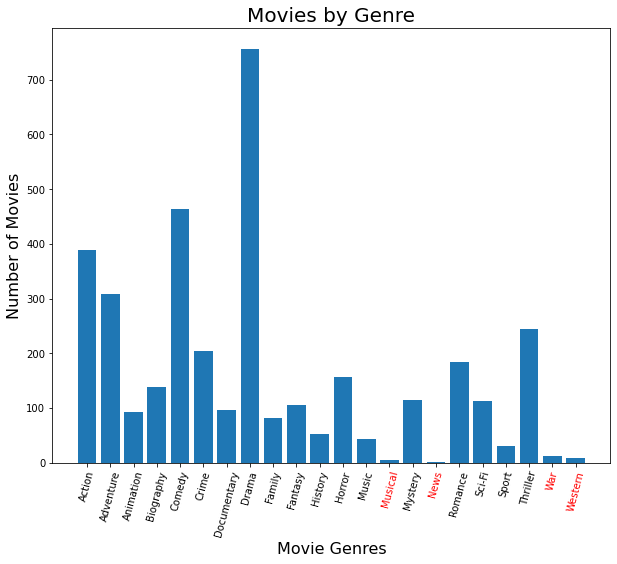

In [26]:

# Creating a bar chart 
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Movies by Genre', fontsize=20)
ax.bar(x=genres_list, height=genres_count)
ax.set_xlabel('Movie Genres')
plt.xticks(rotation=75)
low_counts = [13, 15, 20, 21] #This represents the genres that have low counts 
for tick in low_counts:
    ax.get_xticklabels()[tick].set_color('red')
ax.set_ylabel('Number of Movies');

In [27]:
"""Checking to see what percentage of the total listings by genre each genre
represents.  We likley will throw some additioanl listings out if they do not
represent a large enough portion of the total dataframe in order to not draw 
any conclusions based on data coming from just a few movies."""
print('****************Count of Each Genre*****************')
display(genres_count)
print('**********Percent of total Genre Dataframe**********')
display(((genres_count / len(genres_df)) * 100).round(2))
print(f'Total length of genre_df is {len(genres_df)} records')




****************Count of Each Genre*****************


genres
Action         389
Adventure      309
Animation       92
Biography      138
Comedy         464
Crime          205
Documentary     97
Drama          757
Family          82
Fantasy        105
History         52
Horror         156
Music           43
Musical          5
Mystery        115
News             2
Romance        184
Sci-Fi         112
Sport           31
Thriller       244
War             13
Western          8
Name: movie, dtype: int64

**********Percent of total Genre Dataframe**********


genres
Action         10.80
Adventure       8.58
Animation       2.55
Biography       3.83
Comedy         12.88
Crime           5.69
Documentary     2.69
Drama          21.01
Family          2.28
Fantasy         2.91
History         1.44
Horror          4.33
Music           1.19
Musical         0.14
Mystery         3.19
News            0.06
Romance         5.11
Sci-Fi          3.11
Sport           0.86
Thriller        6.77
War             0.36
Western         0.22
Name: movie, dtype: float64

Total length of genre_df is 3603 records


Looking at the above lists and the associated bar chart, we are going to drop any rows that are associated with the genres of `Musical`, `News`, `Western` and `War` as they each represent less than half of a percent of the total genre dataframe.

In [28]:
# Dropping categories that don't represent at least .5% of the total dataframe
genres_df.drop(['Musical', 'News', 'War', 'Western'], inplace=True)
print(f'The new length of genres_df is {len(genres_df)} records')

The new length of genres_df is 3575 records


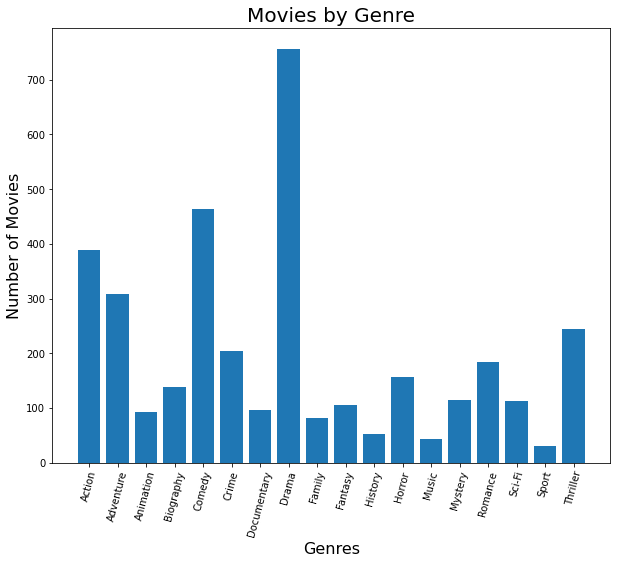

In [29]:
# Re-Creating the bar chart after dropping certain genres
genres_count_rev = genres_df.groupby(by='genres').count()['movie']
genres_list_rev = genres_count_rev.index

fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(x=genres_list_rev, height=genres_count_rev)
ax.set_title('Movies by Genre', fontsize=20)
ax.set_xlabel('Genres')
plt.xticks(rotation=75)
ax.set_ylabel('Number of Movies');


In [30]:
# Getting a genre dataframe of the mean and median by genre
genres_df_median = genres_df.groupby('genres').median()
genres_df_mean = genres_df.groupby('genres').mean()


# When we calculate the means, the dataframe converts some to scientific 
# notation because of extremely long decimal values.  Therefore we are 
#rounding the mean dataframe's columns that would otherwise display in 
#scientific notation
round_columns = ['production_budget', 'domestic_gross', 'worldwide_gross',
                 'profit']
for col in round_columns:
    genres_df_mean[col] = genres_df_mean[col].round(0).astype('int64')

In [31]:
# Taking a look at the median and mean dataframes
display(genres_df_median)
display(genres_df_mean)

,production_budget,domestic_gross,worldwide_gross,profit,ROI,start_year,runtime_minutes,release_month
genres,,,,,,,,
Action,58000000.0,47836282.0,130673154.0,65422946.0,1.312788,2014.0,111.0,7.0
Adventure,100000000.0,83350911.0,251499665.0,132981261.0,1.738285,2014.0,107.0,7.0
Animation,87500000.0,117513830.0,338960585.5,213845751.5,2.004189,2014.0,95.0,7.0
Biography,20000000.0,18050944.0,42372976.5,20287203.5,0.917358,2015.0,116.0,9.5
Comedy,28000000.0,41000099.0,73467226.0,42155734.0,1.623115,2013.0,101.0,7.0
Crime,28000000.0,23591432.0,44264271.0,19535736.0,0.796409,2014.0,109.0,8.0
Documentary,17500000.0,21443494.0,38993548.0,17425450.0,0.744431,2015.0,72.0,7.0
Drama,17500000.0,18007317.0,36964656.0,15264271.0,1.020304,2014.0,109.0,8.0
Family,36500000.0,47852991.5,79190241.5,40089405.5,1.022835,2013.0,102.5,7.5


,production_budget,domestic_gross,worldwide_gross,profit,ROI,start_year,runtime_minutes,release_month
genres,,,,,,,,
Action,82144344,91394766,251244294,169099949,2.077676,2013.922879,113.401028,6.457584
Adventure,107365372,126590686,358843986,251478614,2.261122,2014.080906,110.126214,6.834951
Animation,100307609,140198819,396225573,295917965,2.896903,2013.967391,93.804348,6.989130
Biography,27736846,43080279,89695387,61958541,2.444798,2014.456522,111.688406,8.224638
Comedy,41142392,62573265,143746543,102604151,2.822839,2013.489224,102.096983,6.911638
Crime,33598670,40495854,90254523,56655853,1.299872,2013.595122,110.458537,6.985366
Documentary,32853041,48589282,104645659,71792617,2.573764,2014.319588,61.752577,6.927835
Drama,27490577,35668289,79089031,51598454,2.687996,2013.680317,109.871863,7.266843
Family,60924390,66351640,159539810,98615420,1.710382,2013.012195,101.548780,7.451220


Now that we have the mean and median figures for each genre, we will compare the profit of each to see whether or not they are similar or if we have stark differences between them which could indicate outliers that affect the mean.

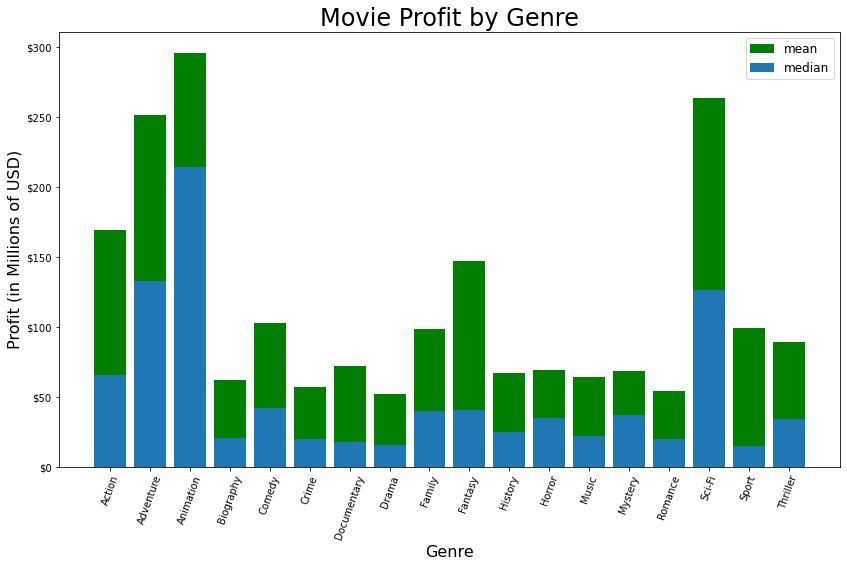

In [32]:
# Creating a plot to compare the mean vs. median movie profit by genre

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,8))

ax.bar(x=genres_df_mean.index, height=genres_df_mean['profit']/1000000,
       color='green', label='mean')
ax.bar(x=genres_df_median.index, height=genres_df_median['profit']/1000000, 
       label='median')
ax.set_title('Movie Profit by Genre')

# Setting properties of the visualization
ax.tick_params(axis='x', rotation = 70)
ax.set_xlabel('Genre')
ax.set_ylabel('Profit (in Millions of USD)')
ax.yaxis.set_major_formatter('${x:.0f}');

ax.legend();

There appear to be some significant differences in between the mean and median profit of each genre.  The fact that this the means are significantly higher than the medians likely indicate the presence of some outliers that skew the central tendency higher when using the mean.  Therefore, we will proceed with looking at the median when dealing with this dataset by genre.

From the above it can be seen that the highest median profit is in the genre of Animation with over $200 million, with the next three genres being Adventure, Sci-fi, and Action.

While understanding the median as a potential expected value, it may also be worthwhile to take a look at the data in terms of Return on Investment.

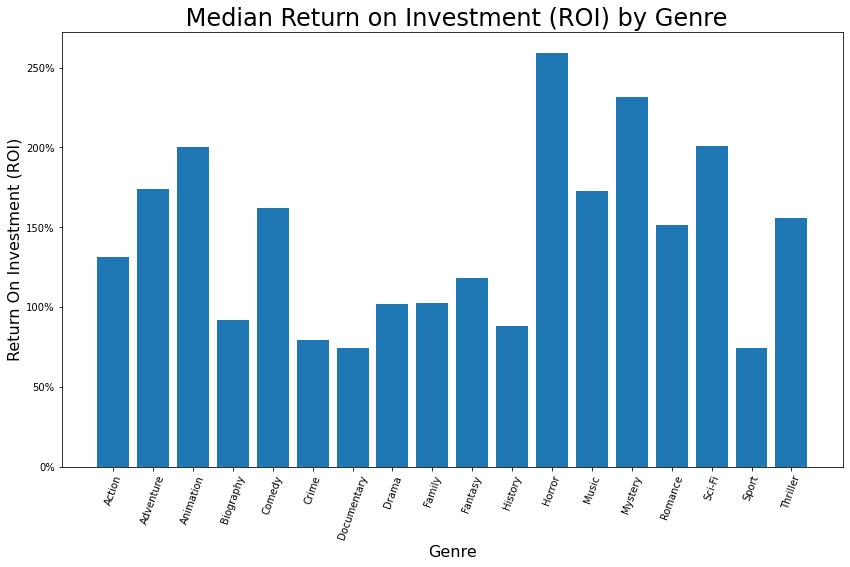

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,8))

ax.bar(x=genres_df_median.index, height=genres_df_median['ROI']*100)
ax.set_title(' Median Return on Investment (ROI) by Genre')

ax.tick_params(axis='x', rotation = 70)
ax.set_xlabel('Genre')
ax.set_ylabel('Return On Investment (ROI)')
ax.yaxis.set_major_formatter('{x:.0f}%');


A quick review of this chart reveals what appear to be a few interesting anomalies.  The Horror, Mystery, Music, Thriller, and Romance genres are on the lower end of the profit spectrum in the first profit chart above. However, on the ROI chart they appear to be significantly higher.  So while these films appear to tend to do well in terms of the amount returned on the investment put in, the raw dollar amount appears to not be as significant for these (which indicates they are often very low budget films.  In fact, we would likely expect them to be on the low end of the budget scale so let's take a look at that.

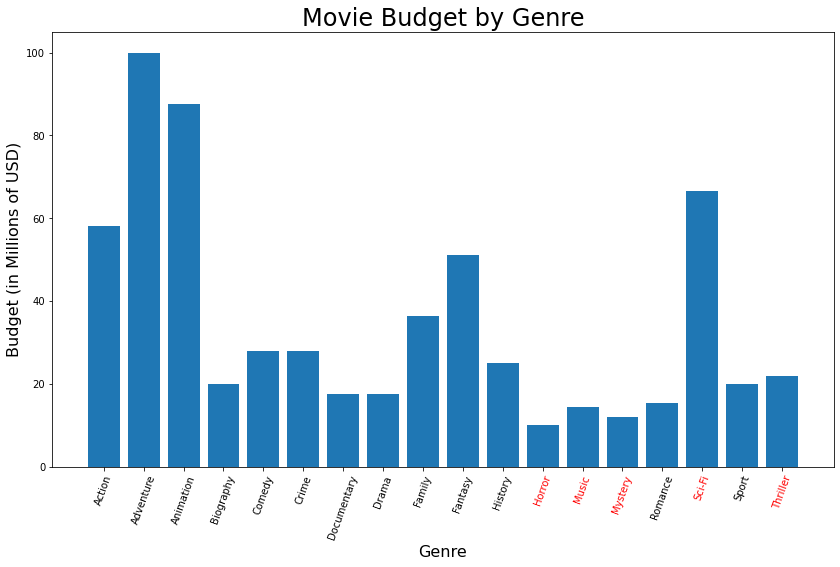

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,8))

ax.bar(x=genres_df_median.index, 
       height=genres_df_median['production_budget']/1_000_000)

ax.set_title('Movie Budget by Genre')

ax.tick_params(axis='x', rotation = 70)
ax.set_xlabel('Genre')
ax.set_ylabel('Budget (in Millions of USD)')
ax.yaxis.set_major_formatter('{x:.0f}');

low_budgets = [11, 12, 13, 15, 17]
for tick in low_budgets:
    ax.get_xticklabels()[tick].set_color('red')



We can see that our assumptions were spot on in terms of the budget allocated to these types movies.  Relatively lower profits with higher ROI would indicate that while the movie didn't make much in total, their low budget allowed their ROI to appear to be very good.  Since Microsoft is a large corporation and likely can afford to spend more on their films, we will focus on the genres that have higher profits and higher ROIs.  Based on the above data, we will recommend Microsoft focus their efforts on an animated film since it is the highest genre by profitability and ranks very high in terms of ROI as well.

### Q2: What Runtime Should Microsoft Target?

To begin to answer this question, and given that we know that we really want to target `profit`, the focus will turn to looking at highly profitable movies and how long their runtimes tend to be.  First, I will filter the `movies_df` dataframe down to only movies with a profit greater than $100 million  Which will give us roughly the top 30\% of movies from the original dataframe.

In [35]:
# filtering down to highly profitable movies and looking at runtimes
highprof_movies = movie_df[movie_df['profit'] > 100_000_000]
# checking to make sure that profit is now a minimum of ~1,000,000
display(highprof_movies['profit'].min())

100759490

In [36]:
# Getting the three highest movies to label in the below plot
highprof_movies.sort_values(by='profit', ascending=False).head(3)

,release_date,production_budget,domestic_gross,worldwide_gross,profit,ROI,start_year,runtime_minutes,genres,release_month
movie,,,,,,,,,,
Avengers: Infinity War,2018-04-27,300000000,678815482,2048134200,1748134200,5.827114,2018,149.0,"[Action, Adventure, Sci-Fi]",4
Jurassic World,2015-06-12,215000000,652270625,1648854864,1433854864,6.669092,2015,124.0,"[Action, Adventure, Sci-Fi]",6
Furious 7,2015-04-03,190000000,353007020,1518722794,1328722794,6.993278,2015,137.0,"[Action, Crime, Thriller]",4


In [37]:
# Getting the average runtime and standard deviation of runtime
runtime_mean = highprof_movies['runtime_minutes'].mean().round()
runtime_std = highprof_movies['runtime_minutes'].std().round()

print(f"runtime mean: {runtime_mean}")
print(f"runtime std dev: {runtime_std}")

runtime mean: 110.0
runtime std dev: 25.0


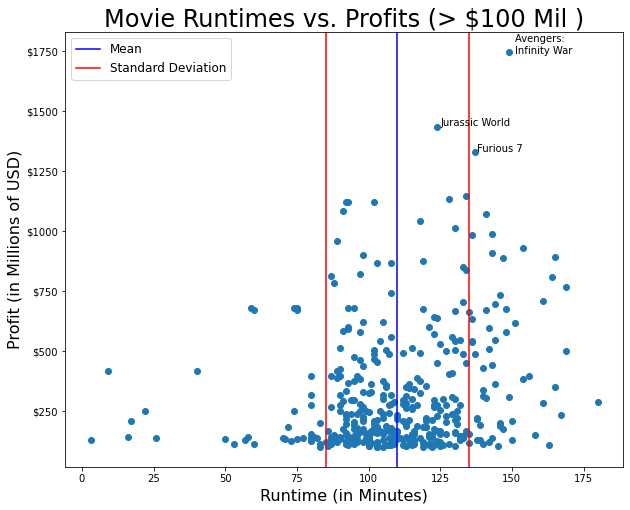

In [38]:
# Plotting the runtimes of the high profit movies
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x=highprof_movies['runtime_minutes'], 
           y=highprof_movies['profit']/1_000_000)
ax.set_title('Movie Runtimes vs. Profits (> $100 Mil )')
ax.set_xlabel('Runtime (in Minutes)')
ax.set_ylabel('Profit (in Millions of USD)')
ax.yaxis.set_major_formatter('${x:.0f}');

# Annotating the three highest profited movies
ax.annotate('Avengers: \nInfinity War', (151, 1740))
ax.annotate('Jurassic World', (125, 1440))
ax.annotate('Furious 7', (138, 1330));

# Including a vertical line for the mean and +/- 1 standard deviation
# Only labeling 1 std. dev. line so it doesn't show up twice in legend
plt.axvline(x=runtime_mean, color='blue', label='Mean')
plt.axvline(x=(runtime_mean + runtime_std), color='red')
plt.axvline(x=(runtime_mean - runtime_std), color='red',
            label='Standard Deviation') 

# Adding the legend
plt.legend()

It is interesting to note that the three movies with the highest profit are all action movies.  Despite these three most profitable movies being between than 125 and 150 minutes, by and large the films with profits greater than $100 million tend to fall between 85 and 135 minutes.  This represents one standard deviation above and below the mean of 110 minutes as illustrated by the vertical lines above.  One standard deviation represents about 67% of all of our data points.

However, this plot represents all films.  Let's take a look back to our `genre_df` dataframe and analyze the runtimes of just the animated films and see if we can further focus our recommendation.

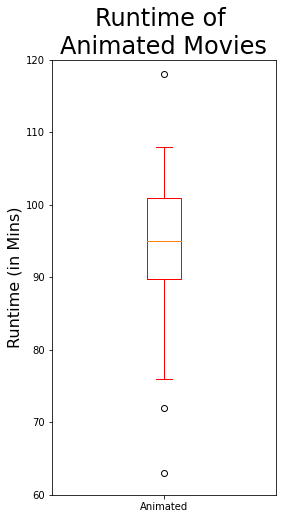

upper quartile: 101.0
        median: 95.0
lower quartile: 89.75

It should be noted there was one movie outlier that was around 20 minutes but it was exluded from this graph for readability


In [39]:
#Plotting all animated films runtime
anim_movies = genres_df[genres_df.index == 'Animation']
anim_movies_rt = anim_movies['runtime_minutes']

fig, ax = plt.subplots(figsize=(4,8))

ax.boxplot(x=anim_movies_rt, boxprops={'color':'red'}, 
           whiskerprops={'color':'red'}, capprops={'color':'red'}, 
           meanprops={'color':'black'})
ax.set_title ('Runtime of \nAnimated Movies')
ax.set_ylabel('Runtime (in Mins)')
ax.set_xticklabels(['Animated'])
plt.ylim(60, 120)
plt.show()

# printing the median and upper and lower quartiles beneath the graph
median=anim_movies_rt.quantile(.5)
lq = anim_movies_rt.quantile(.25)
uq = anim_movies_rt.quantile(.75)

print(f'upper quartile: {uq}')
print(f'        median: {median}')
print(f'lower quartile: {lq}\n')

print('It should be noted there was one movie outlier that was around '
      '20 minutes but it was exluded from this graph for readability')

Based upon the above boxplot, it appears that animated films tend to be slightly shorter in length than the entire population of movies.  Therefore we would recommend to Microsoft to focus on a movie that falls within the interquartile range of animated movie runtimes, or roughly **90-100 minutes**.  

### Q3: What Is the Best Month to Release a Movie?

Now that the analysis of Genre and Runtime are out of the way, we can focus attention upon whether or not the release date of a movie matters.  First we will once again step back and utilize our entire `movie_df` dataset and first look at how many movies are released each month in our dataset.

In [40]:
#Count the movie releases by month and check the result
movie_releases = movie_df.groupby('release_month').count()['release_date']
movie_releases 

release_month
1     106
2      84
3     121
4     118
5     109
6     131
7     122
8     118
9     129
10    147
11    160
12    151
Name: release_date, dtype: int64

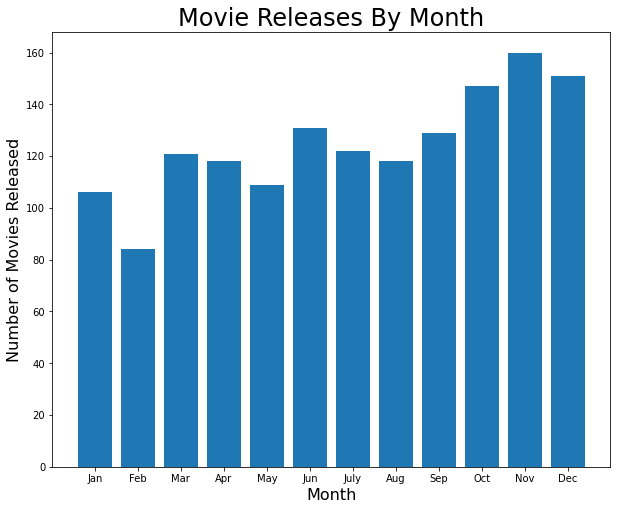

In [43]:
# Creating a bar chart to explore the number of releases by month
fig, ax = plt.subplots(figsize=(10, 8))

release_months = movie_releases.index

ax.bar(x=release_months, height=movie_releases)
ax.set_title('Movie Releases By Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Movies Released')

# Making it so that every bar will have a label
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

Based upon this, we can tell that the months of October, November, and December typically have higher numbers of movies released.  However, before we make a determination based upon the number of releases, let's also review the month of release for a movie vs. the profit that it makes.

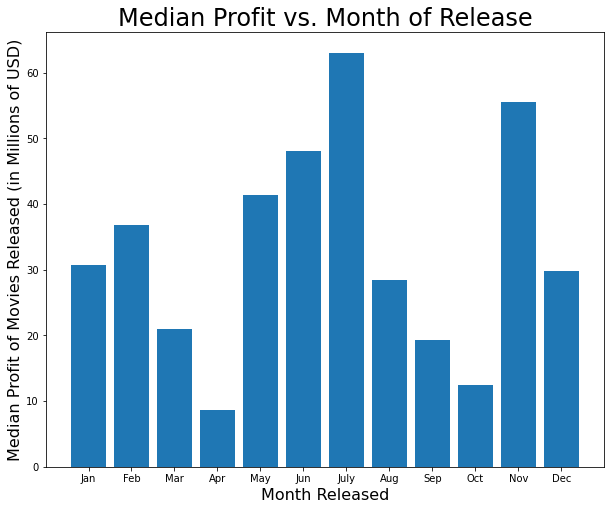

In [44]:
# Creating plot to view profit by release month
# Using the median profit in order to not skew the data based on 
# megablockbusters (which Microsoft is unlikely to have given that this will
# be their first movie)

movie_release_profit = (movie_df.groupby('release_month').median()['profit'] 
                        / 1_000_000)

fig, ax = plt.subplots(figsize=(10,8))
ax.bar(x=release_months, height=movie_release_profit)
ax.set_title('Median Profit vs. Month of Release')
ax.set_xlabel('Month Released')
ax.set_ylabel('Median Profit of Movies Released (in Millions of USD)')

# Making it so that every bar will have a label
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);


We do see a slightly interesting flip here.  Even though more movies are released in October, November, and December, the median profits tend to be highest in the May/Jun/July three month block followed by the November, December, January, and February block.  This would make sense as during the summer months when students are out of schools, many families will go to see movies and in the November through January time frame there are many holiday weekends that are conducive to movie viewing.  It is no surprise that in the months with nicer weather we see a dip in movie profitibility.  Therefore, we would likely recommend that Microsoft **target a summertime release (May through July)** or, alternatively, a holiday season release (November through January).  
***

## Evaluation

The above model does a good job of representing the data we began the task with.  It comes up with concrete recommendations for the business as to what type of movie to produce, the runtime of that move and when the release date should be targeted.  However, there are many factors outside of just these above so while I have confidence in the above recommendations, there is no guarantee that success will follow just from following these factors.  Further considerations as identified below should also be explored as the movie studio project continues to move forward.
___

## Conclusions

Based upon our analysis We have a few recommendations as to what type of movie Microsoft should produce.  If Microsoft follows these suggestions, they should be well placed in their first foray as a movie studio.

### Recommendations

1. Make an **animation film** as they appear to generate the **largest median profits** out of all the movie genres.  In addition, out of all of the movie genre's, animation films **median ROI of just over 200%** is the **third highest ROI** (virtually tied with sci-fi films), behind only horror and mystery.  Microsoft should probably target a **budget of around 87 million USD** as this is the median budget of animated films in our analysis.   **A few alternatives** Microsoft could pursue would be an *Action/Adventure* film (second and fourth respectively in median profits despite slightly lower ROIs) or a *sci-fi* film which is tied for the third highest ROI with animation and boasts the third highest median profit as well.  

2. The runtime should be on the **lower end** of the general runtime range for all movies (85-135 minutes).  This is because it appears that most animated films are somewhere in the **range of 90-100 minutes**.  With an animated film this would make sense since often animated films will be targeted at younger audiences who may have slightly shorter attention spans than adults who may prefer the other genres of movies.  

3. Finally, the **targeted release date** should be during the coveted summer months of **May, June, or July**.  During this time kids are out of school and looking for things to do, parents take time off of work to spend time with their families and may be more likely to take in movies during this time.  In addition, there's no better feeling walking into a nice air-conditioned theater when you're feeling temperatures outside that could fry an egg on the sidewalk.  As **an alternative**, the winter months of **November through January** could be targeted to get in on viewers holiday movie viewing.

![Fried Egg](images/fried-egg.jpg)

### Additional Focuses/Future Research

The above data and analysis should get the Microsoft Movie Studio on its way and into planning for its first movie.  However, there are still additional considerations that will need to be taken into account.  A few of these might be:

1. Research into who Microsoft should target to produce/direct the film. It is possible that a certain **producer, director, writer, or a combination of all three** of a film could have a considerable impact on the performance of a movie.  It would be interesting to see if there is any correlation between these decisions and also consider which producers/directors have historically succeeded in producing/directing animated films of this nature.  IMDB's SQLite database contains tables for directors and writers that could be further incorporated into the analysis and producers details should likely be obtainable from another datasource.

2. Besides the producer/director combination, **certain actors** may also increase the draw for a movie.  An animated film is certainly a slightly more niche genre it may be less important to have many big named actors but rather those who have considerable experience in voice acting.  Although this isn't to say that a major name wouldn't help with the draw.  We could do further research into which actors have considerable experience in Animated movies as well as   This information could be ascertained from the additional IMDB databases.

3. Research the **implications of streaming versus theatrical releases**.  Streaming releases were rare prior to 2020 but the COVID-19 pandemic has changed the movie release calculation considerably.  Microsoft should gather data on and fully analyze more recent data (our data only appears to go through 2018) to ensure that the recommendations above still hold true in the current environment.

4. Microsoft has **many franchises already within its IP catalog**.  This is likely a treasure trove of potential movie material that would likely be worth investigating based on existing adoption of the franchises by Microsoft fans.  This could be a great initial draw to the theaters for a first time movie studio and is likely an advantage many looking to join the fray would not have.